<a href="https://colab.research.google.com/github/hnishi/hello-automl/blob/main/auto_sklearn_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://automl.github.io/auto-sklearn/master/installation.html
# install all dependencies manually
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip -q install
!pip install -q auto-sklearn

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   249  100   249    0     0   1331      0 --:--:-- --:--:-- --:--:--  1331
     |████████████████████████████████| 28.5 MB 45 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 22.3 MB 52.6 MB/s 
     |████████████████████████████████| 722 kB 9.1 MB/s 
     |████████████████████████████████| 973 kB 38.6 MB/s 
     |████████████████████████████████| 118 kB 52.3 MB/s 
     |████████████████████████████████| 4.2 MB 10.2 MB/s 
     |████████████████████████████████| 4.0 MB 8.0 MB/s 
     |████████████████████████████████| 208 kB 8.5 MB/s 
     |███████████████████

In [ ]:
# After upgrading scikit-learn version, you have to restart runtime.
# Ref: https://stackoverflow.com/questions/57831187/need-to-restart-runtime-before-import-an-installed-package-in-colab

# restart rumtime
# Ref: https://stackoverflow.com/questions/53154369/google-colab-how-to-restart-runtime-using-python-code-or-command-line-interf
import os
os.kill(os.getpid(), 9)

In [1]:
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import plot_partial_dependence, permutation_importance

from smac.tae import StatusType
import autosklearn
import autosklearn.classification
import autosklearn.metrics

In [2]:
autosklearn.__version__

'0.13.0'

## Data Loading and Preprocess

Titanic Dataset

X

- pclass: passenger class (1st, 2nd, 3rd), a proxy for socio-economic class
- name: name of passenger
- sex: male or female
- age: age in years (some infants had fractional values)
- sibsp: number of siblings/spouses aboard
- parch: number of parents/children aboard
- ticket: ticket number
- fare: passenger fare
- cabin: cabin number
- embarked: port of embarkation (C: Cherbourg, Q: Queenstown, S: Southampton)
- boat: Lifeboat
- body: body identification number
- home.dest: home/destination

y

- survival: survival (0 = No; 1 = Yes)



In [3]:
# Using Titanic dataset https://www.openml.org/d/40945.
# This example will use the command fetch_openml, which will
# download a properly formatted dataframe if you use as_frame=True.
X, y = sklearn.datasets.fetch_openml(data_id=40945, return_X_y=True, as_frame=True)

In [4]:
# remove columns to be consistent with Kaggle's titanic dataset
X.drop(['name', 'cabin', 'ticket', 'body', 'home.dest', 'boat'], inplace=True, axis=1)

X["pclass"] = X["pclass"].astype("int")
X["sibsp"] = X["sibsp"].astype("int")
X["parch"] = X["parch"].astype("int")        
X["age"] = X["age"].astype("float")        
X["fare"] = X["fare"].astype("float")        
X["embarked"] = X["embarked"].astype("category")
X["sex"] = X["sex"].astype("category")
y = y.astype("category")

In [5]:
# check missing values
for column in X.columns:
    print(f"{column}: {str(sum(X[column].isnull()))} missing values")

pclass: 0 missing values
sex: 0 missing values
age: 263 missing values
sibsp: 0 missing values
parch: 0 missing values
fare: 1 missing values
embarked: 2 missing values


In [6]:
X.dtypes

pclass         int64
sex         category
age          float64
sibsp          int64
parch          int64
fare         float64
embarked    category
dtype: object

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=1
)

## Baseline

In [8]:
# Gender model
# It will predict that all women survive and all men do not survive.
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, X_test["sex"].map(lambda x: '1' if x == "female" else '0')))

Accuracy score 0.7888040712468194


## Build and Fit a Classifier



In [9]:
# the Configuration Space object, from which Auto-Sklearn will sample configurations and build pipelines.
# model.get_configuration_space(X_train, y_train)

In [10]:
%%time
model = autosklearn.classification.AutoSklearnClassifier(
    metric=autosklearn.metrics.accuracy,
    time_left_for_this_task=120,  # in sec
    per_run_time_limit=30,  # in sec
    memory_limit=3072,  # in MB
    resampling_strategy='holdout',
    resampling_strategy_arguments={'train_size': 0.67},
    n_jobs=1,
    seed=2,
    ensemble_size=50,
    # delete_tmp_folder_after_terminate=False,
    # tmp_folder="./autosklearn_tmp"
)
# X_test, y_test will be used to save test predictions for all models. This allows to evaluate the performance of Auto-sklearn over time.
model.fit(X_train, y_train, X_test, y_test, dataset_name='titanic_example')
# model.fit(X_train, y_train, dataset_name='titanic_example')

CPU times: user 10.6 s, sys: 937 ms, total: 11.5 s
Wall time: 1min 55s


In [11]:
# y_train_pred = model.predict(X_train)
# print("Accuracy score", sklearn.metrics.accuracy_score(y_train, y_train_pred))
s = model.score(X_train, y_train)
print(f"Train score {s}")

Train score 0.9039301310043668


In [12]:
# save and load model
import pickle

dump_file = "model.pickle"

with open(dump_file, 'wb') as f:
    pickle.dump(model, f)

with open(dump_file, 'rb') as f:
    restored_model = pickle.load(f)

assert restored_model.score(X_train, y_train) == s

In [13]:
#  the statistics of the training result:
print(model.sprint_statistics())

auto-sklearn results:
  Dataset name: titanic_example
  Metric: accuracy
  Best validation score: 0.825083
  Number of target algorithm runs: 23
  Number of successful target algorithm runs: 21
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 0



## Predict and Evaluate the Final Ensemble

In [14]:
# y_pred = model.predict(X_test)
# print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_pred))
s = model.score(X_test, y_test)
print(f"Test score {s}")

Test score 0.7964376590330788


### The Best Single Model

In [15]:
model.leaderboard(detailed=False, ensemble_only=True, sort_by='cost')

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
13,1,0.04,random_forest,0.174917,2.401085
6,2,0.02,extra_trees,0.181518,2.276615
8,3,0.10,gradient_boosting,0.194719,1.881236
16,4,0.02,extra_trees,0.194719,2.039208
17,5,0.34,adaboost,0.194719,2.274589
2,6,0.06,random_forest,0.204620,2.769130
4,7,0.02,mlp,0.204620,4.405643
10,8,0.08,extra_trees,0.204620,2.706357
20,9,0.04,lda,0.221122,1.076033


In [16]:
# a list of the final ensemble found by auto-sklearn.
list_models = model.get_models_with_weights()
list_models

[(0.34,
  SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'adaboost', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'robust_scaler', 'feature_preprocessor:__choice__': 'extra_trees_preproc_for_classification', 'classifier:adaboost:algorithm': 'SAMME.R', 'classifier:adaboost:learning_rate': 0.046269426995092074, 'classifier:adaboost:max_depth': 3, 'classifier:adaboost:n_estimators': 406, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.002102242030216922, 'data_preprocessing:numerical_transformer:rescaling:robust_scaler:q_max': 0.7697572103377026, 'data_preprocessing:numerical_transformer:rescaling:robust_scaler

In [17]:
model_rf = list_models[6][1]
model_rf.score(X_test, y_test.astype("int"))

0.7175572519083969

In [18]:
model_rf

SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'qda', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:qda:reg_param': 0.585497512341966},
dataset_properties={
  'task': 1,
  'sparse': False,
  'multilabel': False,
  'multiclass': False,
  'target_type': 'classification',
  'signed': False})

### Evaluate the performance of an ensemble model and a single model

In [19]:
%%time
for i in range(10):
  y_pred = model.predict(X_test)

CPU times: user 10.2 s, sys: 3.43 s, total: 13.6 s
Wall time: 9.09 s


In [20]:
%%time
for i in range(10):
  y_pred_rf = model_rf.predict(X_test)

CPU times: user 99 ms, sys: 1.58 ms, total: 101 ms
Wall time: 98.6 ms


### Plot the ensemble performance

Ref: https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_pandas_train_test.html#sphx-glr-examples-40-advanced-example-pandas-train-test-py

In [21]:
def get_runhistory_models_performance(automl):
    metric = automl.automl_._metric
    data = automl.automl_.runhistory_.data
    performance_list = []
    for run_key, run_value in data.items():
        if run_value.status != StatusType.SUCCESS:
            # Ignore crashed runs
            continue
        # Alternatively, it is possible to also obtain the start time with ``run_value.starttime``
        endtime = pd.Timestamp(time.strftime('%Y-%m-%d %H:%M:%S',
                                             time.localtime(run_value.endtime)))
        val_score = metric._optimum - (metric._sign * run_value.cost)
        test_score = metric._optimum - (metric._sign * run_value.additional_info['test_loss'])
        train_score = metric._optimum - (metric._sign * run_value.additional_info['train_loss'])
        performance_list.append({
            'Timestamp': endtime,
            'single_best_optimization_score': val_score,
            'single_best_test_score': test_score,
            'single_best_train_score': train_score,
        })
    return pd.DataFrame(performance_list)

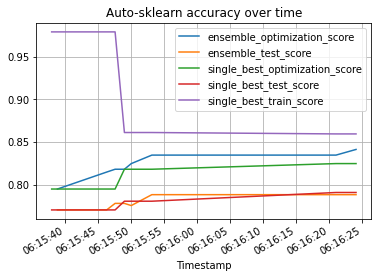

In [22]:
ensemble_performance_frame = pd.DataFrame(model.automl_.ensemble_performance_history)
best_values = pd.Series({'ensemble_optimization_score': -np.inf,
                         'ensemble_test_score': -np.inf})
for idx in ensemble_performance_frame.index:
    if (
        ensemble_performance_frame.loc[idx, 'ensemble_optimization_score']
        > best_values['ensemble_optimization_score']
    ):
        best_values = ensemble_performance_frame.loc[idx]
    ensemble_performance_frame.loc[idx] = best_values

individual_performance_frame = get_runhistory_models_performance(model)
best_values = pd.Series({'single_best_optimization_score': -np.inf,
                         'single_best_test_score': -np.inf,
                         'single_best_train_score': -np.inf})
for idx in individual_performance_frame.index:
    if (
        individual_performance_frame.loc[idx, 'single_best_optimization_score']
        > best_values['single_best_optimization_score']
    ):
        best_values = individual_performance_frame.loc[idx]
    individual_performance_frame.loc[idx] = best_values

pd.merge(
    ensemble_performance_frame,
    individual_performance_frame,
    on="Timestamp", how='outer'
).sort_values('Timestamp').fillna(method='ffill').plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)
plt.show()

## Model Explanation

Ref: https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_inspect_predictions.html#sphx-glr-examples-40-advanced-example-inspect-predictions-py

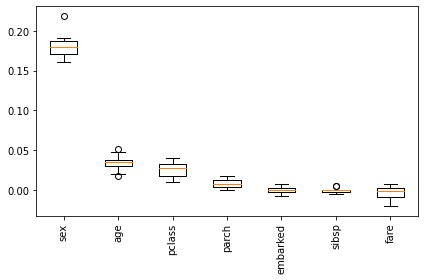

fare      : -0.004 +/- 0.009
sibsp     : -0.001 +/- 0.003
embarked  : -0.000 +/- 0.005
parch     : 0.008 +/- 0.006
pclass    : 0.026 +/- 0.010
age       : 0.035 +/- 0.010
sex       : 0.181 +/- 0.016


In [23]:
# Compute permutation importance
# the permutation importance, which defines the decrease in a model score when a given feature is randomly permuted. So, the higher the score, the more does the model’s predictions depend on this feature.
# see https://christophm.github.io/interpretable-ml-book/feature-importance.html
r = permutation_importance(model, X_test, y_test,
                           n_repeats=10,
                           random_state=0)

sort_idx = r.importances_mean.argsort()[::-1]
plt.boxplot(r.importances[sort_idx].T, labels=[X_test.columns[i] for i in sort_idx])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(f"{X_test.columns[i]:10s}: {r.importances_mean[i]:.3f} +/- "
          f"{r.importances_std[i]:.3f}")

## Experiment: Remove Outliers before AutoML

In [24]:
# use Z-score to find outliers
# z = (x – μ) / σ
def outliers_z_score(data, threshold=6):
    outliers=[]
    for i in data:
        z_score = (i - np.mean(data)) / np.std(data)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

In [25]:
outliers = X_train[["age", "fare", "parch", "sibsp"]].apply(outliers_z_score, axis=0)
outliers

age                                  []
fare     [512.3292, 512.3292, 512.3292]
parch                         [9, 6, 6]
sibsp       [8, 8, 8, 8, 8, 8, 8, 8, 8]
dtype: object

In [26]:
X_train_wo_outliers = X_train.copy()
X_train_wo_outliers["survival"] = y_train
for i in outliers.keys():
  X_train_wo_outliers = X_train_wo_outliers[X_train_wo_outliers[i].map(lambda x: x not in outliers[i])]
  print(X_train_wo_outliers.shape)

y_train_wo_outliers = X_train_wo_outliers["survival"]
X_train_wo_outliers.drop("survival", axis=1, inplace=True)

(916, 8)
(913, 8)
(910, 8)
(901, 8)


In [27]:
%%time
model_wo_outliers = autosklearn.classification.AutoSklearnClassifier(
    metric=autosklearn.metrics.accuracy,
    time_left_for_this_task=120,  # in sec
    per_run_time_limit=30,  # in sec
    memory_limit=3072,
    resampling_strategy='holdout',
    resampling_strategy_arguments={'train_size': 0.67},
    n_jobs=1,
    seed=2,
    ensemble_size=50,
    # delete_tmp_folder_after_terminate=False,
    # tmp_folder="./autosklearn_tmp"
)
# X_test, y_test will be used to save test predictions for all models. This allows to evaluate the performance of Auto-sklearn over time.
model_wo_outliers.fit(X_train_wo_outliers, y_train_wo_outliers, X_test, y_test, dataset_name='titanic_example')

CPU times: user 15.5 s, sys: 1.42 s, total: 16.9 s
Wall time: 2min 1s


In [28]:
s = model_wo_outliers.score(X_test, y_test)
print(f"Test score {s}")

Test score 0.7913486005089059


## auto-sklearn 2.0



In [29]:
# https://automl.github.io/auto-sklearn/master/api.html#autosklearn.experimental.askl2.AutoSklearn2Classifier
import autosklearn.experimental.askl2

In [30]:
%%time
model_2 = autosklearn.experimental.askl2.AutoSklearn2Classifier(
    metric=autosklearn.metrics.accuracy,
    time_left_for_this_task=120,  # in sec
    per_run_time_limit=30,  # in sec
    memory_limit=3072,
    n_jobs=1
)
# X_test, y_test will be used to save test predictions for all models. This allows to evaluate the performance of Auto-sklearn over time.
model_2.fit(X_train, y_train, X_test, y_test, dataset_name='titanic_example')

/usr/local/lib/python3.7/dist-packages/smac/intensification/parallel_scheduling.py:155: UserWarning: SuccessiveHalving is intended to be used with more than 1 worker but num_workers=1
  num_workers


CPU times: user 7.7 s, sys: 1.51 s, total: 9.21 s
Wall time: 2min 1s


In [31]:
y_pred_2 = model_2.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_pred_2))

Accuracy score 0.8015267175572519
